In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
from tqdm.notebook import tqdm
from statistics import mean

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models

from models.old_model import SiameseNetwork
from models.new_model import NewSiameseNetwork
from models import pretrained_model

from losses.euclidean import ContrastiveLoss
from losses.cosine import ContrastiveLossCosine
from losses.triplet import TripletLoss

from utils.vis_utils import imshow, show_plot, example_vis
from utils.other_utils import joinpath, NetworkDataset, TestNetworkDataset, get_dataset
# from utils.other_utils import intersection, threshold

# from embeddings.create_embeddings import create_embeddings
# from embeddings.mean_embeddings import mean_embeddings

# from scoring.test_report import test_report

In [2]:
# Setup the path where images are located
PATH = r"H:\Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning\data\RGBFace_no_background"

# save the model path
MODEL_PATH = r"H:\Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning\saved_model\example_testing"

# Setup the number of channels in the image, 3 for color, 1 for monochrome
nchannel=3

# no of epoch
EPOCH = 5

# whether it is triplet or contrastive
FLAG = 'contrastive'
# FLAG = 'triplet'

# rotation flag
ROTATION = False

# if testing
testing = False

# Threshold score
THRESHOLD_SCORE = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print(torch.cuda.get_device_name())
    torch.cuda.empty_cache()

NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# Resize the images and transform to tensors
if ROTATION:
    transformation = transforms.Compose([transforms.Resize((224,224)),
        transforms.ToTensor(), 
        transforms.RandomApply([
            transforms.RandomRotation([-30,30])], p = 0.2)
    ])
else:
    # transformation = transforms.Compose([transforms.Resize((100,100)),
    #                                  transforms.ToTensor()])
    transformation = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])] 
                                     )

In [4]:
os.cpu_count() #cpu count

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


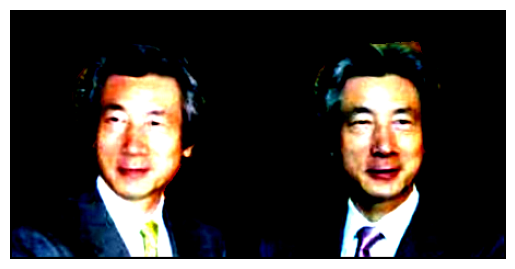

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]


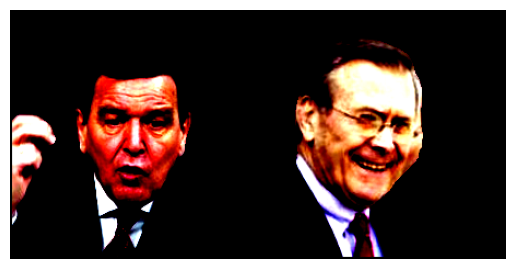

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.]


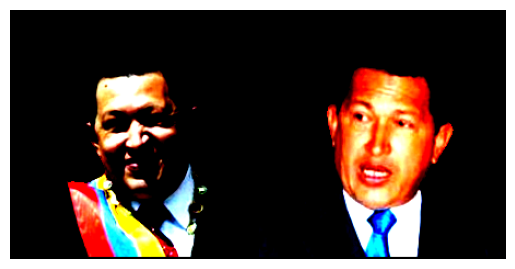

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]


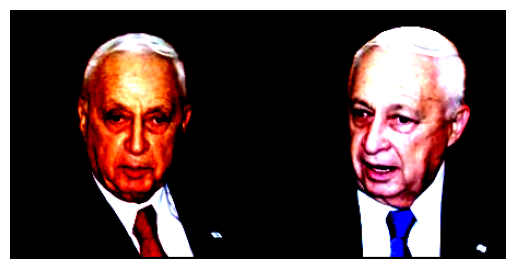

[0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


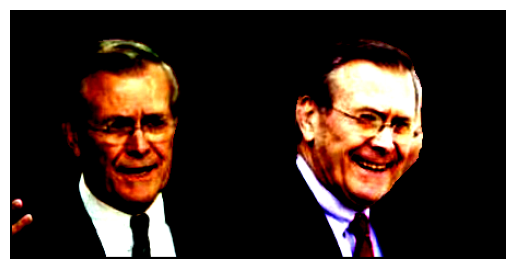

[0.]


In [5]:
vis_dataloader,_ =  get_dataset(joinpath(PATH,'train'), nchannel, transformation,NetworkDataset,FLAG,0,1,True)
example_vis(vis_dataloader,FLAG)

In [6]:
train_dataloader,_ = get_dataset(joinpath(PATH,'train'), nchannel, transformation,NetworkDataset,FLAG,0,64,True)

In [7]:
net = pretrained_model.SiameseNetwork().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0005)
if FLAG == 'contrastive':
    criterion = ContrastiveLoss()
elif FLAG == 'triplet':
    criterion = TripletLoss()

h:\anaconda3\envs\torch_capstone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
h:\anaconda3\envs\torch_capstone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
print(net)

SiameseNetwork(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [9]:
def contrastive_train(net,optimizer,criterion,epochs=EPOCH):
    loss_history = []
    for epoch in tqdm(range(epochs), desc='Epochs'):
        # Iterate over batches
        for i, (img0, img1, label) in enumerate(train_dataloader, 0):

            # Send the images and labels to CUDA
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = net(img0, img1)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = criterion(output1, output2, label)

            # Calculate the backpropagation
            loss_contrastive.backward()

            # Optimize
            optimizer.step()
        # save the loss history for each epoch
        loss_history.append(loss_contrastive.item())
    return(loss_history)

In [10]:
def triplet_train(net,optimizer,criterion,epochs=EPOCH):
    loss_history = []
    for epoch in tqdm(range(EPOCH), desc="Epochs"):
        # Iterate over batches
        for step, (anchor_img, positive_img, negative_img,_,_,_) in enumerate(train_dataloader,0):
            # Send the images and labels to CUDA
            anchor_img, positive_img, negative_img = anchor_img.to(device), positive_img.to(device), negative_img.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Pass in the three images into the network and obtain three outputs
            anchor_out = net.forward_once(anchor_img)
            positive_out = net.forward_once(positive_img)
            negative_out = net.forward_once(negative_img)
            
            # Pass the outputs of the networks and label into the loss function
            loss_triplet = criterion(anchor_out, positive_out, negative_out)

            # Calculate the backpropagation
            loss_triplet.backward()

            # Optimize
            optimizer.step()
        # save the loss history for each epoch
        loss_history.append(loss_triplet.item())
    return loss_history

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

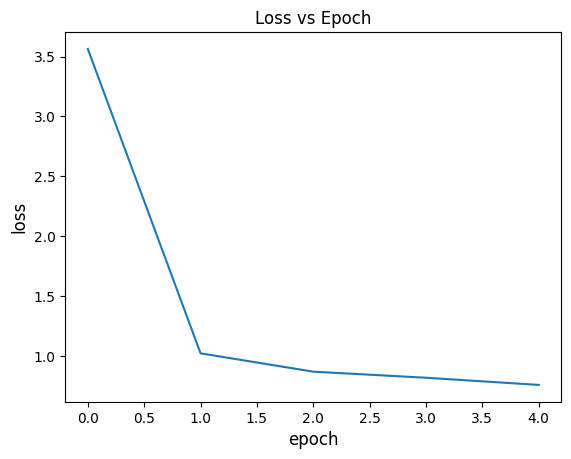

In [11]:
if FLAG == 'contrastive':
    train_loss = contrastive_train(net,optimizer,criterion)
    # _,train_loss = train()
elif FLAG == 'triplet':
    train_loss = triplet_train(net,optimizer,criterion)
plt.figure()
plt.title('Loss vs Epoch')
plt.xlabel("epoch", fontsize=12)
plt.ylabel("loss", fontsize=12)
counter = list(range(len(train_loss)))
show_plot(counter, train_loss)

In [28]:
import pickle

# open a file in binary write mode
with open(joinpath(MODEL_PATH,'loss_list.pkl'), 'wb') as f:
    # pickle the two lists
    pickle.dump(train_loss, f)


In [12]:
# PATH = "my_trained_model_exampling.pt"

torch.save(net.state_dict(), joinpath(MODEL_PATH,'model.pt'))
